![uc3m](http://materplat.org/wp-content/uploads/LogoUC3M.jpg)

## Sergio Aizcorbe (100406602)
## Bernardo Bouzas (100406634)



---




#### Mount Google Drive, install dependencies and download the database. Since the database will take up to 10 minutes to download, continue reading the next sections.
 

In [ ]:
# Load the Drive helper and mount
#from google.colab import drive

# This will prompt for authorization.
#drive.mount('/content/drive')

# Create a new folder in your drive and change to that directory as: 
# /content/drive/My_Drive/new_dir_that_you_just_created_for_this_lab
#import os
#os.chdir('/content/drive/My Drive/TAVVA/2021-22/Labs/L7-ASR with Deep Learning')

In [ ]:
!pip install pydub

In [ ]:
import os
import pdb
import torchaudio
from torchaudio.datasets import LIBRISPEECH

#Content data is a local folder for the node, this will accelerate the training process, but requires that you download the dataset every time you run the notebook
data_path = './data'
#If you need persistence, and want to avoid future downloads, you can set a path in google drive. However, be aware that this will make the training process slower

if not os.path.isdir(data_path):
    os.makedirs(data_path)

trainDataset = LIBRISPEECH(data_path, url="train-clean-100", download=True)
testDataset = LIBRISPEECH(data_path, url="test-clean", download=True)

print("done")

  0%|          | 0.00/5.95G [00:00<?, ?B/s]

  0%|          | 0.00/331M [00:00<?, ?B/s]

done


# LAB SESSION 7
---

# Deep Learning for ASR

### Audio Processing, Video Processing and Computer Vision

### Bachelor in Data Science and Engineering
### Academic Course 2021/2022



1. INTRODUCTION AND OBJECTIVES
2. UTILITY FUNCTIONS
3. THE DATASET
4. EVALUATING A SPEECH RECOGNITION MODEL
5. THE SPEECH RECOGNITION MODEL
6. THE TRAINING AND TESTING CODE


NOTE: you will find sections in this notebook called exercises, which are the ones you are expected to report for evaluation. You will also find questions as comments in the code. Those are for you to think about, but we don't expect those to be handed over to us.

---
## 1. INTRODUCTION AND OBJECTIVES
---
In this lab session, we are going to work with a deep network that performs automatic speech recognition using pytorch. This is, you give the model an audio file containing the voice of a person speaking english, and as the model 
will output a text string containing (hopefully) the words said by that person.

To train such network with need voice audio files along with the text the model is expected to generate, hence, (voice, utterance) pairs. The [LibriSpeech](http://www.openslr.org/12/) dataset contains exactly that kind of data.

The general architecture of the system is inspired on DeepSpeech 2 (by Baidu), and shown in the next illustration

![Intro](https://landen.imgix.net/blog_KKMFzSYvUskeYQpX/assets/BHOBfDVTcGCQKTtp.png)

Before diving into the code, here is a general overview of the complete system:


1.   The audio is loaded and transformed into a spectrogram (we just changed from audio input to image input).
2.   The spectrogram is passed through a CNN that computes visual features for different time-instants. At this point, a time instant is a bunch of columns from the spectrogram image.
3.   The visual features are passed through a linear layer to accomodate the data dimensionality.
4.   The processed visual features of each audio segment (time-instant) are used as a sequence in a recurrent neural network (RNN)
5.   A final linear layer + softmax estimates, for each visual feature, the probability of being each possible letter. For that end, a CTC module and loss are employed to generate and align output sequences and labels. 
6.   Finally, the decoder generates the final text output.




---
## 2. UTILITY FUNCTIONS
---

We need to execute now some utility functions that the rest of the code uses. In this session, there is only this TextTransform class. 


In [ ]:
class TextTransform:
    """Maps characters to integers and vice versa"""
    def __init__(self):
        char_map_str = """
        ' 0
        <SPACE> 1
        a 2
        b 3
        c 4
        d 5
        e 6
        f 7
        g 8
        h 9
        i 10
        j 11
        k 12
        l 13
        m 14
        n 15
        o 16
        p 17
        q 18
        r 19
        s 20
        t 21
        u 22
        v 23
        w 24
        x 25
        y 26
        z 27
        """
        self.char_map = {}
        self.index_map = {}
        for line in char_map_str.strip().split('\n'):
            ch, index = line.split()
            self.char_map[ch] = int(index)
            self.index_map[int(index)] = ch
        self.index_map[1] = ' '

    def text_to_int(self, text):
        """ Use a character map and convert text to an integer sequence """
        int_sequence = []
        for c in text:
            if c == ' ':
                ch = self.char_map['<SPACE>']
            else:
                ch = self.char_map[c]
            int_sequence.append(ch)
        return int_sequence

    def int_to_text(self, labels):
        """ Use a character map and convert integer labels to a text sequence """
        string = []
        for i in labels:
            string.append(self.index_map[i])
        return ''.join(string).replace('<SPACE>', ' ')

In [ ]:
text_transform = TextTransform()
texts = ['','A A','HELLO WORLD']

for t in texts:
    tti = text_transform.text_to_int(t.lower())
    print(f'Text: \n{t}')
    print("Is encoded as:")
    print(tti, "\n")

Text: 

Is encoded as:
[] 

Text: 
A A
Is encoded as:
[2, 1, 2] 

Text: 
HELLO WORLD
Is encoded as:
[9, 6, 13, 13, 16, 1, 24, 16, 19, 13, 5] 



---
## 3. THE DATASET
---

In pytorch, we use the [Dataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) class to read samples from disk and prepare them to be inputs of the model.

Read the code and try to understand the different methods. Then, awnser the proposed questions in EXERCISE 1 


In [ ]:
import os
import time
import numpy as np
import numpy.random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchaudio

from pydub import AudioSegment
from pydub.playback import play
from torchaudio.datasets import LIBRISPEECH

In [ ]:
np.random.seed(42)

class LibriSpeech(LIBRISPEECH):
    
    """
    A dataset class derived from the torchaudio.datasets.LIBRISPEECH class.
    The intention is to zip in this class all code related to loading the
    training and test input samples for the model.
    
    Each sample in the dataset has 6 entries:
        waveform, sample_rate, utterance, speaker_id, chapter_id, utterance_id
    """
    
    def __init__(self, path, mode, n_feats, download=True, num_data=None):
        
        url = "train-clean-100" if mode == 'train' else "test-clean"
        super(LibriSpeech, self).__init__( path, url=url, download=download)
        
        if not os.path.isdir(path):
            os.makedirs(path)
        
        if mode == "train":
            self.audioTransforms = nn.Sequential(
                torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=n_feats),
                torchaudio.transforms.FrequencyMasking(freq_mask_param=30),
                torchaudio.transforms.TimeMasking(time_mask_param=100)
            )
        elif mode == "test":
            self.audioTransforms = nn.Sequential(
                torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=n_feats)
            )
        else:
            raise RuntimeError("Unsupported mode: must be train or test")
                      
        if num_data:
          self.num_data = num_data
          self.idx = np.random.choice(LIBRISPEECH.__len__(self), size=num_data,replace=True)
        else:
          self.num_data = LIBRISPEECH.__len__(self)
          self.idx = np.arange(self.num_data)

        self.text_transform = TextTransform()
    
    def __len__(self):
      return self.num_data

    def __getitem__(self, n, return_raw=False):
        
        """
        This function is called to retrieve each dataset sample. First, it
        recovers the raw sample from the original torchaudio LIBRISPEECH 
        dataset (origSample), that contains the waveform and utterance transcript 
        
            origSample = (tensor[1,numSamples], str)
            
            then, it applies the audio transformations defined on this class 
        constructor (that turns the [1,numSamples] audio signal into a [M,N] 
        spectrogram image) and encode the string utterance into a list of integers.
        
            spec = tensor[T, mel_coeffs]
            label = list[len(utterance)]

            mel_coeffs is the number of MEL coefficients used to compute the 
        spectrogram (the frequency dimension) and T is the resulting length of
        the spectrogram (the time dimension) (check MelSpectrogram to understand
        the relation between the original audio duration and the resulting 
        spectrogram length)
        
        """
        origSample = LIBRISPEECH.__getitem__(self, self.idx[n])
        (waveform, _, utterance, _, _, _) = origSample
        
        spec = self.audioTransforms(waveform).squeeze(0).transpose(0, 1)
        label = torch.Tensor(self.text_transform.text_to_int(utterance.lower()))
        
        if not return_raw:
            return spec, label
        else:
            return waveform, spec, utterance, label
    
    
    def collate(self, data):
    
        """
        This function is used by the DataLoaders to build the data batches
        that are inputs of the speech recognition model.
        
        It receives as input a list of N tuples (N = batch size). Each tuple is
        generated by this class method __getitem__(), like this:
            
            data = [ (spec1,label1), (spec2,label2), ...]
        
        The function stacks all the spectrograms and labels accounting
        for the different lengths by means of a zero padding scheme.
        The output is:

            spectrograms = [N, 1, mel_coeffs, maxT]
            labels       = [N, maxCharacters]
            inputLengths = half the original spec lengths before the padding
            labelLengths = original label lengths before the padding
        
        """
        
        spectrograms = []
        labels = []
        specLengths = []
        labelLengths = []
        
        for spec, label in data:
            
            spectrograms.append(spec)
            labels.append(label)
            
            specLengths.append(spec.shape[0]//2)
            labelLengths.append(len(label))
    
        spectrograms = nn.utils.rnn.pad_sequence(
            spectrograms, batch_first=True
        ).unsqueeze(1).transpose(2, 3)

        labels = nn.utils.rnn.pad_sequence(labels, batch_first=True)
    
        return spectrograms, labels, specLengths, labelLengths

/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:595: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


Visualize sample 1


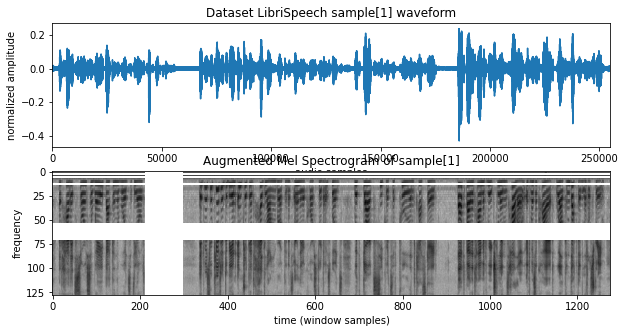



Original transcription and generated labels

THAT HAD ITS SOURCE AWAY BACK IN THE WOODS OF THE OLD CUTHBERT PLACE IT WAS REPUTED TO BE AN INTRICATE HEADLONG BROOK IN ITS EARLIER COURSE THROUGH THOSE WOODS WITH DARK SECRETS OF POOL AND CASCADE BUT BY THE TIME IT REACHED LYNDE'S HOLLOW IT WAS A QUIET WELL CONDUCTED LITTLE STREAM
THAT HAD ITS SOURCE AWAY BACK IN THE WOODS OF THE OLD CUTHBERT PLACE IT WAS REPUTED TO BE AN INTRICATE HEADLONG BROOK IN ITS EARLIER COURSE THROUGH THOSE WOODS WITH DARK SECRETS OF POOL AND CASCADE BUT BY THE TIME IT REACHED LYNDE'S HOLLOW IT WAS A QUIET WELL CONDUCTED LITTLE STREAM
tensor([21.,  9.,  2., 21.,  1.,  9.,  2.,  5.,  1., 10., 21., 20.,  1., 20.,
        16., 22., 19.,  4.,  6.,  1.,  2., 24.,  2., 26.,  1.,  3.,  2.,  4.,
        12.,  1., 10., 15.,  1., 21.,  9.,  6.,  1., 24., 16., 16.,  5., 20.,
         1., 16.,  7.,  1., 21.,  9.,  6.,  1., 16., 13.,  5.,  1.,  4., 22.,
        21.,  9.,  3.,  6., 19., 21.,  1., 17., 13.,  2.,  4.,  6.,  1., 

In [ ]:
path = "./data"
mode = "train"
n_feats = 128
download = True

trainDataset = LibriSpeech(path, mode, n_feats, download=download)

# get a sample and plot the original audio and transcription with their
# corresponding augmented spectrogram and labels transformations

i = 1
print(f"Visualize sample {i}")

samplei = trainDataset.__getitem__(i, return_raw=True)
(waveform, spec, utterance, label) = samplei

plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(waveform.t().numpy())
plt.xlim([0, waveform.shape[1]])
plt.xlabel("audio samples")
plt.ylabel("normalized amplitude")
plt.title(f"Dataset LibriSpeech sample[{i}] waveform")

plt.subplot(2, 1, 2)
plt.imshow(spec.T.log2().detach().numpy(), cmap='gray_r', aspect='auto')
plt.xlabel("time (window samples)")
plt.ylabel("frequency")
plt.title(f"Augmented Mel Spectrogram of sample[{i}]")
plt.show()

print("\n\nOriginal transcription and generated labels\n")
print(utterance)
print(text_transform.int_to_text(label.tolist()).upper())
print(label)

# lets build a batch of two samples to check the dimensions of the network
# inputs
print("\n\nBuild a batch of samples and check the dimensions")
sample0, sample1 = trainDataset[0], trainDataset[1]
data = (sample0, sample1)
batch = trainDataset.collate(data)

spectrograms, labels, specLengths, labelLengths = batch
print("spectroams shape")
print(spectrograms.shape)
print("labels shape")
print(labels.shape)

We next hear the speech of the two samples. The next cell only works in local mode and not in Google Colab.

In [ ]:
#Function that plays a numpy array of samples
def playSample(samples):
    #Convert to 16bit-unsigned integer
    samplesb = np.int16(samples * 2 ** 15)

    audio_segment = AudioSegment(
        samplesb.tobytes(), 
        frame_rate=16000,
        sample_width=2, 
        channels=1
    )
    play(audio_segment)

In [ ]:
# #Play sample 0
# playSample(trainDataset.__getitem__(0,return_raw=True)[0].numpy())
# #Play sample 1
# playSample(trainDataset.__getitem__(1,return_raw=True)[0].numpy())

---
### [EXERCISE 1]
---

The LibriSpeech class is responsible of preparing the input data  for
the speech recognition models. It must read the audio files with their
corresponding transcriptions from disk, and apply all the necessary 
transformations (depending on whether the data is for train or test)

In particular, note that this class computes spectrograms (which are two
dimensional signals that usually are visualized as images).

Asnwer the following questions in the cell above:

1.   Are we losing any information from the original audio signals by
      transforming them into MEL spectrograms and giving the model just that?
      In other words, can you recover the original audio signal from the spectrogram alone?
2.   If deep learning is about models learning what features to extract
      from the raw data, why aren't we giving the network the raw
      audio signals?
3.   Can you explain the data augmentation mechanism implemented in this 
      class? (FrequencyMasking and TimeMasking functions), what would you listen by playing the augmented samples in comparison with the original ones?

      HINT: Try to find information such as [this](https://arxiv.org/abs/1706.09559) analyzing the first two questions of this exercise.


### EX 1 - QUESTION 1

> When an audio signal is transformed by MFCC, the great detail of individual frames information is always lost in the process. Therefore, a lower-quality signal can be recovered, which is very similar to the original one, but not as precise. 

>Moreover, there exists a method that could optimize this reconstruction process by minimizing loss: the **Griffin-Lim Algorithm** is a phase reconstruction technique based on the short-time Fourier transform's redundancy. It promotes spectrogram consistency by iterating two projections (a spectrogram is said to be consistent when its inter-bin dependency is preserved due to STFT redundancy).

> While this approach is often used for cases in which there is a modified STFT/spectrogram of some real signal, or one generated by a neural network, it might be useful in reconstructing the signal with less loss of information.


### EX 1 - QUESTION 2

> Learning acoustic models directly from the raw waveform data is quite complex and, in our particular case, would be unproductive and lead to poor results. Given the relatively low number of layers that our neural networks have, we believe that they are insufficient for building high-level discriminative features. If we were to feed our model with raw signals we would encounter a ***high occurrence of noise***, giving rise to frequency bands that would only hinder and worsen our speech recognition model. 

> Using time-domain waveforms as inputs might be more reliable if we had CNNs with **dozens of weight layers**, being optimized over very long sequences, and the application was not for speech recognition, which is not the case.

### EX 1 - QUESTION 3

> The first function iteratively applies a concealment or screening (masking) to the **frequency channels [f0, f0+f]** of the spectrogram. It randomly picks “f” and “f0” from two uniform distributions: for the first, 0 to frequency mask parameter F. For the second, 0 to (number of freq. channels - f). It is performed until it reaches the length of the mask.  When listening to these modified versions, the weaker sound will be inaudible, as the brain will only process the masking sound. This effect will be even more pronounced especially if the weaker sound has a frequency closer to the masking sound.


> In the temporal masking function, a similar process is applied, but to the **time domain**: it obscures one sound by another, but in this case it occurs when the signal and the masker are not presented simultaneously. It iteratively masks t time steps [t0, t0+t].  It randomly picks “t” and “t0” from two uniform distributions: for the first, 0 to time mask parameter T. For the second, 0 to (number of time channels - t). When listening to these modified versions, the masking sound will make the masked sound inaudible. In this situation, the more intense tone tends to mask the weaker tone. Depending on the instant of time at which the masking stimulus occurs relative to the instant at which the masking occurs, a distinction should be able to be made: post-masking and pre-masking.

---
## 4. EVALUATING A SPEECH RECOGNITION MODEL
---

In image classification it is common to have a single integer label for each test image. Thus, metrics such as accuracy or confusion matrices are common for evaluating those systems. 

However, in a speech recognition problem we have two sentences with potentially different lengths:

1.   The ground truth one:  containing the actual words that were spoken
2.   The model prediction:  containing the transcription of our model outputs

How do we measure how well the sentences produced by the model fit the ground truth?. Two common metrics are the Character and Word Error Rates (CER, WER). The formulas and explanations for computing them are in the next code cell as comments inside the functions. In the main section of the next cell there are also some examples to help you understand the metrics.

Execute the cell, play with the samples and try to answer the questions in excersice 2.






In [ ]:
def _levenshtein_distance(ref, hyp):
    """Levenshtein distance is a string metric for measuring the difference
    between two sequences. Informally, the levenshtein disctance is defined as
    the minimum number of single-character edits (substitutions, insertions or
    deletions) required to change one word into the other. We can naturally
    extend the edits to word level when calculate levenshtein distance for
    two sentences.
    """
    m = len(ref)
    n = len(hyp)

    # special case
    if ref == hyp:
        return 0
    if m == 0:
        return n
    if n == 0:
        return m

    if m < n:
        ref, hyp = hyp, ref
        m, n = n, m

    # use O(min(m, n)) space
    distance = np.zeros((2, n + 1), dtype=np.int32)

    # initialize distance matrix
    for j in range(0,n + 1):
        distance[0][j] = j

    # calculate levenshtein distance
    for i in range(1, m + 1):
        prev_row_idx = (i - 1) % 2
        cur_row_idx = i % 2
        distance[cur_row_idx][0] = i
        for j in range(1, n + 1):
            if ref[i - 1] == hyp[j - 1]:
                distance[cur_row_idx][j] = distance[prev_row_idx][j - 1]
            else:
                s_num = distance[prev_row_idx][j - 1] + 1
                i_num = distance[cur_row_idx][j - 1] + 1
                d_num = distance[prev_row_idx][j] + 1
                distance[cur_row_idx][j] = min(s_num, i_num, d_num)

    return distance[m % 2][n]


def word_errors(reference, hypothesis, ignore_case=False, delimiter=' '):
    """Compute the levenshtein distance between reference sequence and
    hypothesis sequence in word-level.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param delimiter: Delimiter of input sentences.
    :type delimiter: char
    :return: Levenshtein distance and word number of reference sentence.
    :rtype: list
    """
    if ignore_case == True:
        reference = reference.lower()
        hypothesis = hypothesis.lower()

    ref_words = reference.split(delimiter)
    hyp_words = hypothesis.split(delimiter)
    
    edit_distance = _levenshtein_distance(ref_words, hyp_words)
    return float(edit_distance), len(ref_words)


def char_errors(reference, hypothesis, ignore_case=False, remove_space=False):
    """Compute the levenshtein distance between reference sequence and
    hypothesis sequence in char-level.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param remove_space: Whether remove internal space characters
    :type remove_space: bool
    :return: Levenshtein distance and length of reference sentence.
    :rtype: list
    """
    if ignore_case == True:
        reference = reference.lower()
        hypothesis = hypothesis.lower()

    join_char = ' '
    if remove_space == True:
        join_char = ''

    reference = join_char.join(filter(None, reference.split(' ')))
    hypothesis = join_char.join(filter(None, hypothesis.split(' ')))
    
    edit_distance = _levenshtein_distance(reference, hypothesis)
    return float(edit_distance), len(reference)


def wer(reference, hypothesis, ignore_case=False, delimiter=' '):
    """Calculate word error rate (WER). WER compares reference text and
    hypothesis text in word-level. WER is defined as:
    .. math::
        WER = (Sw + Dw + Iw) / Nw
    where
    .. code-block:: text
        Sw is the number of words substituted,
        Dw is the number of words deleted,
        Iw is the number of words inserted,
        Nw is the number of words in the reference
    We can use levenshtein distance to calculate WER. Please draw an attention
    that empty items will be removed when splitting sentences by delimiter.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param delimiter: Delimiter of input sentences.
    :type delimiter: char
    :return: Word error rate.
    :rtype: float
    :raises ValueError: If word number of reference is zero.
    """
    edit_distance, ref_len = word_errors(reference, hypothesis, ignore_case, delimiter)

    if ref_len == 0:
        raise ValueError("Reference's word number should be greater than 0.")

    wer = float(edit_distance) / ref_len
    return wer


def cer(reference, hypothesis, ignore_case=False, remove_space=False):
    """Calculate charactor error rate (CER). CER compares reference text and
    hypothesis text in char-level. CER is defined as:
    .. math::
        CER = (Sc + Dc + Ic) / Nc
    where
    .. code-block:: text
        Sc is the number of characters substituted,
        Dc is the number of characters deleted,
        Ic is the number of characters inserted
        Nc is the number of characters in the reference
    We can use levenshtein distance to calculate CER. Chinese input should be
    encoded to unicode. Please draw an attention that the leading and tailing
    space characters will be truncated and multiple consecutive space
    characters in a sentence will be replaced by one space character.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param remove_space: Whether remove internal space characters
    :type remove_space: bool
    :return: Character error rate.
    :rtype: float
    :raises ValueError: If the reference length is zero.
    """
    edit_distance, ref_len = char_errors(reference, hypothesis, ignore_case, remove_space)

    if ref_len == 0:
        raise ValueError("Length of reference should be greater than 0.")

    cer = float(edit_distance) / ref_len
    return cer

In [ ]:
refs = ['HELLO', 'HELLO', 'HELLO WORLD', 'SUP']
hyps = ['HELLO', 'HELLA', 'HELLO WORLL', 'YOUR MODEL OUTPUTS TOO MANY WORDS']

for ref, hyp in zip(refs, hyps):
    print(f'Real text (ground truth labels)): {ref}')
    print(f'Predicted text (Model output)): {hyp}')
    print(f'CER rate: {cer(ref, hyp):.2f}')
    print(f'WER rate: {wer(ref, hyp):.2f}\n')

Real text (ground truth labels)): HELLO
Predicted text (Model output)): HELLO
CER rate: 0.00
WER rate: 0.00

Real text (ground truth labels)): HELLO
Predicted text (Model output)): HELLA
CER rate: 0.20
WER rate: 1.00

Real text (ground truth labels)): HELLO WORLD
Predicted text (Model output)): HELLO WORLL
CER rate: 0.09
WER rate: 0.50

Real text (ground truth labels)): SUP
Predicted text (Model output)): YOUR MODEL OUTPUTS TOO MANY WORDS
CER rate: 10.33
WER rate: 6.00



### [EXERCISE 2]

- Describe how CER and WER are computed based on the results of the examples executed below (you can use any other illustrative example that you find appropriate).

- In your opinion, which metric is more suitable to assess the capability of the ASR system? 


### EX 2 - QUESTION 1

> To measure the accuracy with CER and WER, instead of evaluating the output indicating 1 for a complete match or 0 for no match, we break these matches down to the word and character level. In this way, we use these error rates to determine the precise extent, on whatever scale we want, to which the prediction and GT differ from each other. It is not simply counting how many words or characters are misspelled, but the possibility of overshooting or undershooting comes into play. For this, as explained in the theory, we use the Levenshtein distance, which allows us to know the minimum number of edits (words or characters, for WER or CER respectively) that are required to change one structure (again, respectively sentence or word) into another. These edits can be **substitution, deletion or insertion** errors.

> For example, calculating the CER for **'HELLO’ (gt) vs 'HELLA’**, we have 1 substitution, 0 deletions and 0 insertions, being 5 the number of characters of the GT (and in this case of the predicted output too), so the CER = (1+0+0)/5 = 0.2

> Calculating the WER for **'SUP' (gt) vs 'YOUR MODEL OUTPUTS TOO MANY WORDS'**, we have that the number of words of the ground truth is 1, but in the predicted output we would have 1 misspelling (SUP vs YOUR) and 5 insertions, so WER = (1 + 0 + 5)/1 = 6.


### EX 2 - QUESTION 2

> We have conducted some research, and we believe that the industry standard is using the Word Error Rate (WER) as evaluation metric, so a lower word error rate shows superior accuracy in recognition of speech. However, we have found that in a Microsoft Research experiment, it was shown that, if people were trained under "that matches the optimization objective for understanding", (Wang, Acero and Chelba, 2003) they would show a higher accuracy in understanding of language than other people who showed a lower word error rate. Evidently these are different situations, deep learning models vs. human performance, but since the ultimate goal of these algorithms is to match their recognition capability to ours, perhaps it is not unreasonable to think that the true understanding of spoken language relates to more than just highly accurate word recognition. 

> For us it makes more sense to use the CER, since the characters are always of invariable size (1), while the size of the words varies enormously. In addition, a word is incorrectly recognized if just one letter in it is not correct, so it does not seem to us to be a very “fair” or consistent criterion.

---
## 4. THE SPEECH RECOGNITION MODEL
---

The next code cell contains the speech recognition model class: SpeechRecognitionModel. The following code does not exactly implement the model depicted in the figure in section 1 but a simplified version with a vainilla RNN. 

Take a look at the main at the end of the code cell and answer the questions in excercise 3.






In [ ]:
class CNNLayerNorm(nn.Module):
    """
    This class is a convenience to do the transposition of the tensor, since
    we want to normalize the features and not the time dimensions.
    
    This is similar to a batchnorm layer but you apply it before the conv layers
    not after (pretty much the same idea with minor modifications). 
    """
    def __init__(self, n_feats):
        super(CNNLayerNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(n_feats)

    def forward(self, x):
        # x (batch, channel, feature, time)
        x = x.transpose(2, 3).contiguous() # (batch, channel, time, feature)
        x = self.layer_norm(x)
        return x.transpose(2, 3).contiguous() # (batch, channel, feature, time) 


class ResidualCNN(nn.Module):
    """
    This is basically a block of convolutional residual network. Since the
    input and output has the same dimensions (as long as the stride=1)
    you can stack as many as you want.
    
    """
    def __init__(self, in_channels, out_channels, kernel, stride, dropout, n_feats):
        super(ResidualCNN, self).__init__()

        self.cnn1 = nn.Conv2d(in_channels, out_channels, kernel, stride, padding=kernel//2)
        self.cnn2 = nn.Conv2d(out_channels, out_channels, kernel, stride, padding=kernel//2)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.layer_norm1 = CNNLayerNorm(n_feats)
        self.layer_norm2 = CNNLayerNorm(n_feats)

    def forward(self, x):
        residual = x  # (batch, channel, feature, time)
        x = self.layer_norm1(x)
        x = F.gelu(x)   
        x = self.dropout1(x)
        x = self.cnn1(x)
        x = self.layer_norm2(x)
        x = F.gelu(x)
        x = self.dropout2(x)
        x = self.cnn2(x)
        x += residual
        return x # (batch, channel, feature, time)
    
class SimpleRNN(nn.Module):

    def __init__(self, rnn_dim, hidden_size, dropout, batch_first):
        super(SimpleRNN, self).__init__()

        self.RNN = nn.RNN(
            input_size=rnn_dim, hidden_size=hidden_size,
            num_layers=1, batch_first=batch_first)
        
        self.layer_norm = nn.LayerNorm(rnn_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.layer_norm(x)
        x = F.gelu(x)
        x, _ = self.RNN(x)
        x = self.dropout(x)
        return x
    
class SimpleGRU(nn.Module):
    
    def __init__(self, rnn_dim, hidden_size, dropout, batch_first, bidirectional=False):
        super().__init__()
        
        self.GRU = nn.GRU(
            input_size=rnn_dim,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=batch_first,
            bidirectional=bidirectional
        )
        self.layer_norm = nn.LayerNorm(rnn_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.layer_norm(x)
        x = F.gelu(x)
        x, _ = self.GRU(x)
        x = self.dropout(x)
        return x

In [ ]:
class SpeechRecognitionModel(nn.Module):
    
    def __init__(self, n_cnn_layers, n_rnn_layers, rnn_dim, n_class, n_feats,
                 stride=2, dropout=0.1, use_GRU=False, bidirectionalRNN=False):
        
        super(SpeechRecognitionModel, self).__init__()
        
        n_feats = n_feats // stride
        self.cnn = nn.Conv2d(1, 32, 3, stride=stride, padding=3//2)  # cnn for extracting heirachal features

        # n residual cnn layers with filter size of 32
        self.rescnn_layers = nn.Sequential(*[
            ResidualCNN(32, 32, kernel=3, stride=1, dropout=dropout, n_feats=n_feats) 
            for _ in range(n_cnn_layers)
        ])
        #Linear
        self.fully_connected = nn.Linear(n_feats*32, rnn_dim)

        #RNN
        if use_GRU:
            self.recursive_layers = nn.Sequential(*[
                SimpleGRU(
                    rnn_dim=rnn_dim if (i==0 or not bidirectionalRNN) else 2*rnn_dim,
                    hidden_size=rnn_dim,
                    dropout=dropout,
                    batch_first=i==0,
                    bidirectional=bidirectionalRNN
                )
              for i in range(n_rnn_layers)
            ])
        else:
            self.recursive_layers = nn.Sequential(*[
                SimpleRNN(
                    rnn_dim=rnn_dim,
                    hidden_size=rnn_dim,
                    dropout=dropout,
                    batch_first=i==0
                )
              for i in range(n_rnn_layers)
            ])
        if bidirectionalRNN:
            output_channels = 2 * rnn_dim
        else:
            output_channels = rnn_dim
        #Final Classifier with stack of linear layers
        self.classifier = nn.Sequential(
            nn.Linear(output_channels, rnn_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(rnn_dim, n_class)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = self.rescnn_layers(x)
        sizes = x.size()
        x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])  # (batch, feature, time)
        x = x.transpose(1, 2) # (batch, time, feature)
        x = self.fully_connected(x)
        x = self.recursive_layers(x)
        x = self.classifier(x)
        return x

In [ ]:
def get_sr_model(model, model_params, device='cpu'):
    return model(
        model_params['n_cnn_layers'], model_params['n_rnn_layers'],
        model_params['rnn_dim'], model_params['n_class'], model_params['n_feats'],
        model_params['stride'], model_params['dropout'],
        model_params['use_gru'], model_params['bidirectional']
    ).to(device)

In [ ]:
print('entra')

# these are the options of the model
hparams = {
    "n_cnn_layers": 1,
    "n_rnn_layers": 2,
    "rnn_dim": 256,
    "n_class": 29,
    "n_feats": 128, # number of mel coeffs in the spectrogram
    "stride":2,
    "dropout": 0.1,
    "use_gru": True,
    "bidirectional": True,
}

model = get_sr_model(SpeechRecognitionModel, hparams)

# Lets go over each step in the forward method of the SpeechRecognitionModel
# to understand the inputs and outputs of each submodule inside it

# generate a batch with a single image to use as model input (just noise
# with the proper dimensions)
x = torch.randn(1, 1, 128, 1249)

# the model first uses a 32 filter conv layer with a stride of 2 which halves
# the time and frequency dimensions of the input spectrogram
x = model.cnn(x) # x.shape = [1, 32, 64, 625]

# then it goes through the residual backbone preserving its shape
x = model.rescnn_layers(x) # x.shape = [1, 32, 64, 625]

# now the x volume its reshaped to join all features
sizes = x.size()
x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])  # (batch, feature, time)
x = x.transpose(1, 2) # (batch, time, feature) with x.shape = [1, 625, 2048]

# at this point we have 625 time instants, each represented by a 2048 feature vector
# we compress the 2048 feature vectors into 512 ones using a fully connected
x = model.fully_connected(x) # x.shape = [1, 625, 512] (numImage,timeInstant,Feature)

# now, we use the recurrent layer that will give us for each of the 625
# time instants, a feature vector of dimension 512 
x = model.recursive_layers(x) # x.shape = [1, 625, 512]

# finally, we need a classifier to take every of the 625 feature vectors (of
# dimensionality 512) coming out of the rnn and give a distribution of 
# scores over each possible letter
x = model.classifier(x) # x.shape = [1, 625, 29]

# to get the final text out of x, you need to implement some strategy
# such as the one in the greedyDecoder function provided.
print(x.shape)

entra
torch.Size([1, 625, 29])


---
### [EXERCISE 3]
---

In the previous cell, define a new class `SimpleGRU` and integrate it into the SpeechRecognitionModel class, by filling the blank spaces where code is required.

This class should be inspired in the SimpleRNN class, but substituting the vainilla RNN by a GRU layer with the possibility of being bidirectional. The constructor method should have the following interface:

`__init__(self, rnn_dim, hidden_size, dropout, batch_first,bidirectional=False)`

In addition, in order to get a class compatible with the pretrained weights provided in the practice, the object implementing the GRU layer should be called: `self.GRU`

HINT for integration: Bidirectional recursive layers are internally implemented in pytorch as two
    individual layers (but sharing weights), each of them looking at the input data in reverse order
    from each other. Both individual outputs are then concatenated into a 
    final tensor. Thus, the dimension of the output gets doubled with 
    respect to a non bidirectional GRU. This will cause the first fc layer in 
    the classifier to fail if not taken into account. Change the fc layer that receives the RNN 
    output to expect rnn_dim*2 as input dimension when using 
    bidirectional=True option.
    



---
## 4. TRAINING AND TESTING THE ASR MODEL
---

The next code cell contains all the necessary to train and test the speech recognition model. Check that we are using the CTC loss to train our network.


In [ ]:
text_transform = TextTransform()

def GreedyDecoder(output, labels, label_lengths, blank_label=28, collapse_repeated=True):
    arg_maxes = torch.argmax(output, dim=2)
    decodes = []
    targets = []
    for i, args in enumerate(arg_maxes):
        decode = []
        targets.append(text_transform.int_to_text(labels[i][:label_lengths[i]].tolist()))
        for j, index in enumerate(args):
            if index != blank_label:
                if collapse_repeated and j != 0 and index == args[j-1]:
                    continue
                decode.append(index.item())
        decodes.append(text_transform.int_to_text(decode))
    return decodes, targets


class IterMeter(object):
    """keeps track of total iterations"""
    def __init__(self):
        self.val = 0

    def step(self):
        self.val += 1

    def get(self):
        return self.val


def train(model, device, train_loader, criterion, optimizer, scheduler, epoch, iter_meter):
    model.train()
    data_len = len(train_loader.dataset)
    print(f'Train Epoch: {epoch} lr = {scheduler.get_lr()[0]}')

    for batch_idx, _data in enumerate(train_loader):
        spectrograms, labels, input_lengths, label_lengths = _data 
        spectrograms, labels = spectrograms.to(device), labels.to(device)

        optimizer.zero_grad()

        output = model(spectrograms)  # (batch, time, n_class)
        output = F.log_softmax(output, dim=2)
        output = output.transpose(0, 1) # (time, batch, n_class)
        loss = criterion(output, labels, input_lengths, label_lengths)
        loss.backward()

        optimizer.step()
        scheduler.step()
        iter_meter.step()
        if batch_idx % 100 == 0 or batch_idx == data_len:
            print('Train Epoch: {} [{:04}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(spectrograms), data_len,
                100. * batch_idx / len(train_loader), loss.item()))
            

def test(model, device, test_loader, criterion):
    print('\nEvaluating...')
    model.eval()
    test_loss = 0
    test_cer, test_wer = [], []

    with torch.no_grad():
        for i, _data in enumerate(test_loader):
            spectrograms, labels, input_lengths, label_lengths = _data 
            spectrograms, labels = spectrograms.to(device), labels.to(device)

            output = model(spectrograms)  # (batch, time, n_class)
            output = F.log_softmax(output, dim=2)
            output = output.transpose(0, 1) # (time, batch, n_class)
            
            loss = criterion(output, labels, input_lengths, label_lengths)
            test_loss += loss.item() / len(test_loader)

            decoded_preds, decoded_targets = GreedyDecoder(output.transpose(0, 1), labels, label_lengths)
            for j in range(len(decoded_preds)):
                test_cer.append(cer(decoded_targets[j], decoded_preds[j]))
                test_wer.append(wer(decoded_targets[j], decoded_preds[j]))

    avg_cer = sum(test_cer)/len(test_cer)
    avg_wer = sum(test_wer)/len(test_wer)

    print(f'\nTest set: Average loss: {test_loss:.4f}, Average CER: {avg_cer:4f} Average WER: {avg_wer:.4f}\n')
    print('\nEXAMPLE')
    print('GT:')
    print(decoded_targets[-1])
    print("\nNetwork output:")
    print(decoded_preds[-1])

    return list(zip(decoded_targets, decoded_preds, test_cer, test_wer)), (avg_cer, avg_wer, test_loss)

In [ ]:
def get_dataloader(dataset, batch_size, use_cuda, num_workers, shuffle=True):
    kwargs = {'num_workers': num_workers, 'pin_memory': True} if use_cuda else {}
    return data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        collate_fn=dataset.collate,
        **kwargs
    )

In [ ]:
def trainloop(model_params, training_params, device, use_cuda, num_workers=2):

    # Subsample the training dataset and limit the number of utterances to 10000 (,num_data=10000)
    train_dataset = LibriSpeech(training_params['db_path'], "train", model_params['n_feats'])
    test_dataset =  LibriSpeech(training_params['db_path'], "test", model_params['n_feats'])

    train_loader = get_dataloader(
        train_dataset,
        batch_size=training_params['batch_size'],
        shuffle=True, use_cuda=use_cuda,
        num_workers=num_workers
    )
    test_loader = get_dataloader(
        test_dataset,
        batch_size=training_params['batch_size'],
        shuffle=False, use_cuda=use_cuda,
        num_workers=num_workers
    )

    model = get_sr_model(SpeechRecognitionModel, model_params, device)

    print('Num Model Parameters', sum([param.nelement() for param in model.parameters()]))

    criterion = nn.CTCLoss(blank=28).to(device)
    optimizer = optim.AdamW(model.parameters(), training_params['learning_rate'])
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=training_params['learning_rate'], 
        steps_per_epoch=int(len(train_loader)),
        epochs=training_params['epochs'],
        anneal_strategy='linear'
    )

    spath = training_params['weights_path']
    if not os.path.isdir(spath):
        os.makedirs(spath)


    init_epoch = 1
    iter_meter = IterMeter()

    for epoch in range(init_epoch, training_params['epochs'] + 1):
        t = time.time()
        train(model, device, train_loader, criterion, optimizer, scheduler, epoch, iter_meter)
        
        if epoch % 5 == 0:
            test(model, device, test_loader, criterion)
            torch.save(model.state_dict(), spath + f'/model_{model_params["name"]}_epoch_{epoch}.tar')
            
        print(f'Elapsed time {(time.time() - t)/60.0:.2f} minutes')

In [ ]:
import copy
"""
Use this code to train a model with a particular group of settings. Before
changing any values make sure you understand what they are there for.

You can try to vastly improve the CER,WER by using a predictive dictionary
and fix miss-spellings in the model outputs.
"""    
torch.manual_seed(7)

training_params = {
    "learning_rate": 5e-4,
    "batch_size": 10,
    "epochs": 20,
    "db_path": data_path,
    "weights_path": data_path + "/weights"
}

rnn_params = {
    'name': 'rnn',
    "n_cnn_layers": 2,
    "n_rnn_layers": 2,
    "rnn_dim": 512,
    "n_class": 29,
    "n_feats": 128,
    "stride": 2,
    "dropout": 0.1,
    "use_gru": False,
    "bidirectional": False,
}
gru_params = rnn_params.copy()
gru_params['name'] = 'gru'
gru_params['use_gru'] = True

bigru_params = gru_params.copy()
bigru_params['name'] = 'bigru'
bigru_params['bidirectional'] = True

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

models_params = [rnn_params, gru_params, bigru_params]
# models_params = [gru_params, bigru_params]

for params in models_params:
    trainloop(params, training_params, device, use_cuda, num_workers=2)

Num Model Parameters 4518365
Train Epoch: 1 lr = 2e-05


/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:595: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:1565: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Train Epoch: 1 [0000/28539 (0%)]	Loss: 7.200567
Train Epoch: 1 [1000/28539 (4%)]	Loss: 3.160992
Train Epoch: 1 [2000/28539 (7%)]	Loss: 2.937017
Train Epoch: 1 [3000/28539 (11%)]	Loss: 2.889538
Train Epoch: 1 [4000/28539 (14%)]	Loss: 2.862601
Train Epoch: 1 [5000/28539 (18%)]	Loss: 2.880747
Train Epoch: 1 [6000/28539 (21%)]	Loss: 2.803498
Train Epoch: 1 [7000/28539 (25%)]	Loss: 2.890071
Train Epoch: 1 [8000/28539 (28%)]	Loss: 2.837659
Train Epoch: 1 [9000/28539 (32%)]	Loss: 2.859166
Train Epoch: 1 [10000/28539 (35%)]	Loss: 2.892515
Train Epoch: 1 [11000/28539 (39%)]	Loss: 2.845295
Train Epoch: 1 [12000/28539 (42%)]	Loss: 2.852150
Train Epoch: 1 [13000/28539 (46%)]	Loss: 2.830335
Train Epoch: 1 [14000/28539 (49%)]	Loss: 2.878073
Train Epoch: 1 [15000/28539 (53%)]	Loss: 2.798177
Train Epoch: 1 [16000/28539 (56%)]	Loss: 2.802028
Train Epoch: 1 [17000/28539 (60%)]	Loss: 2.702271
Train Epoch: 1 [18000/28539 (63%)]	Loss: 2.561703
Train Epoch: 1 [19000/28539 (67%)]	Loss: 2.570950
Train Epoch: 

### [EXERCISE 4]:

Describe why the input parameter (blank=28) means when initializating the CTC Loss. Explain the utility of this element and why the value is 28.

### EX 4 - QUESTION 1

> Classical speech recognition algorithms would need the transcript text to be aligned with the audio before training, and the model would be taught to predict specific labels at specific intervals. Forcing every input step to correspond to some output rarely makes sense. The input may contain periods of silence with no matching output, or we sometimes have no way to produce outputs with multiple characters in a row. 

> The CTC loss function is unique in that it makes it possible to avoid this process. During training, our model will learn to align the transcript by itself. The "**blank**" label added by CTC, also known as epsilon, allows the model to identify that a particular audio frame did not produce a character. Or when dealing with repeated characters, if a word has two of the same character in a row, then a valid alignment must have a blank (or epsilon) between them. With this rule in place, we can differentiate between alignments which collapse correctly and incorrectly when merging.

> As our model predicts 28 classes, the blank is set to 28, which means that the blank label is the class with index 28.

### Testing Models

The training process to learn the optimal parameters of an ASR model is slow and may take several hours. Hence, we are providing you with 3 models that can be directly tested as long as the previous required code is correct. If you do not have time to train your own models, you can ommit the previous cell and directly jump the next one. 

In [ ]:
def get_model_path(spath, params):
    
    if params.get('use_gru'):
        if params.get('bidirectional'):
            model_name = '/model_bigru.tar'
        else:
            model_name = '/model_gru.tar'
    else:
        model_name = '/model_rnn.tar'
    
    return spath + model_name

In [ ]:
#This cell is to load and evaluate a model that has been previously trained and saved to disk

def testloop(model_path, model_params, test_params, device, use_cuda, num_workers=2):
    torch.manual_seed(7)

    test_dataset =  LibriSpeech(test_params['db_path'], "test", model_params['n_feats'])
    test_loader = get_dataloader(
        test_dataset,
        batch_size=test_params['batch_size'],
        shuffle=False, use_cuda=use_cuda,
        num_workers=num_workers
    )

    model = get_sr_model(SpeechRecognitionModel, model_params, device)

    print(100 * '-', f'\nModel: {model_params["name"]}')
    print('Num Model Parameters:', sum([param.nelement() for param in model.parameters()]))

    if os.path.exists(model_path):
        print(f'Loading pre-trained network from {model_path}')
        model.load_state_dict(torch.load(model_path), strict=True)

    return test(
        model, device, test_loader,
        criterion=nn.CTCLoss(blank=28).to(device)
    )

### [EXERCISE 5]

Evaluate the ASR considering 3 options:
- a) The original ASR model with the vainilla RNN
- b) The ASR model, but substituting the vainilla RNN by a GRU layer
- c) The ASR model, but substituting the vainilla RNN by a bidirectional GRU layer

Compare the results in terms of Average CER, WER and Loss, and include the GT and output senteces provided by the three options. Include a discussion about the results explaining why some options are better than others.

In [ ]:
test_params = {
    "batch_size": 32,
    "db_path": data_path,
}
rnn_params = {
    'name': 'rnn',
    "n_cnn_layers": 2,
    "n_rnn_layers": 2,
    "rnn_dim": 512,
    "n_class": 29,
    "n_feats": 128,
    "stride": 2,
    "dropout": 0.0,
    "use_gru": False,
    "bidirectional": False,
}

gru_params = rnn_params.copy()
gru_params['name'] = 'gru'
gru_params['use_gru'] = True

bigru_params = gru_params.copy()
bigru_params['name'] = 'bigru'
bigru_params['bidirectional'] = True

models_params = [rnn_params, gru_params, bigru_params]


use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

model_results = {}
for mparams in models_params:

    st = time.time()

    results, avg_metrics = testloop(
        f'./data/weights/model_{mparams.get("name")}_epoch_20.tar',
        mparams, test_params,
        device, use_cuda
    )
    print(f'\nElapsed time for {mparams.get("name").upper()} model: {(time.time() - st)//60}m {int((time.time() - st)%60)}s\n')

    model_results[mparams.get('name')] = [results, avg_metrics]


---------------------------------------------------------------------------------------------------- 
Model: rnn
Num Model Parameters 2417117
Loading pre-trained network from ./data/weights/model_rnn_epoch_20.tar

Evaluating...


/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:595: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "



Test set: Average loss: 0.7824, Average CER: 0.241363 Average WER: 0.6802


EXAMPLE
GT:
i love thee with a love i seemed to lose with my lost saints i love thee with the breath smiles tears of all my life and if god choose i shall but love thee better after death

Network output:
i  love the with a love i seemed to thee with my lost sans i love be with the bre smiile ye ares of al mi elife and if go ches i shawd byt loved the better after dath

Elapsed time for RNN model: 6.0m 21s

---------------------------------------------------------------------------------------------------- 
Model: gru
Num Model Parameters 4518365
Loading pre-trained network from ./data/weights/model_gru_epoch_20.tar

Evaluating...

Test set: Average loss: 0.6142, Average CER: 0.185658 Average WER: 0.5534


EXAMPLE
GT:
i love thee with a love i seemed to lose with my lost saints i love thee with the breath smiles tears of all my life and if god choose i shall but love thee better after death

Network output:
i 

In [ ]:
def display_results(results, n_samples=5):

    for model, (examples, avgs) in results.items():
        print(100 * "-", f'\n\nMODEL: {model.upper()}')
        [print(f'{k}: {v}') for k, v in zip(('Avg. CER', 'Avg. WER', 'Avg. Loss'), avgs)]

        print(f'\nEXAMPLES ({n_samples})')
        for (gt, pred, cer, wer) in examples[:n_samples]:
            print(f'Ground Truth: {gt}')
            print(f'Prediction: {pred}')
            print(f'CER: {cer}')
            print(f'WER: {wer}', end='\n\n')

    print(100 * '-')

In [ ]:
display_results(model_results, n_samples=5)

---------------------------------------------------------------------------------------------------- 

MODEL: RNN
Avg. CER: 0.24136258807830188
Avg. WER: 0.6801813814750154
Avg. Loss: 0.7824004670468775

EXAMPLES (5)
Ground Truth: why a tongue impress'd with honey from every wind
Prediction: wy at tong inmpressd with huny from every wind 
CER: 0.27848101265822783
WER: 0.7142857142857143

Ground Truth: why an ear a whirlpool fierce to draw creations in
Prediction: wi an ear a worl pop fercse to drok reeations bem 
CER: 0.14285714285714285
WER: 0.5

Ground Truth: all is said without a word
Prediction: all was seid without a worrd 
CER: 0.19230769230769232
WER: 0.7222222222222222

Ground Truth: i sit beneath thy looks as children do in the noon sun with souls that tremble through their happy eyelids from an unaverred yet prodigal inward joy
Prediction: i set bene thi looks as choltren do in the newn son with sols that chremble thrugh their happy i amlys from an un ofverd yet pronicle inwo

### EX 5 - QUESTION 1

> As seen in the **results printed just above**, there is a clear difference in accuracy between the three models. **The most accurate is the Bidirectional GRU**, followed by the GRU and finally the vanilla RNN. This makes sense, since the GRU is a variation of the conventional RNN specifically conceived to solve the Vanishing-Exploding gradients problem, and, within it, the bidirectional is an even more advanced concept. It is therefore logical that the more specifically the architecture is designed, the better it will be at solving the problem, and so it is.

> On the other hand, we have found that in terms of time consumption, the 3 are really similar in the test stage, so that once trained, it makes sense to use the Bidirectional GRU. However, we have noticed that **during the training phase the computational cost is directly proportional to the quality of the posterior predicted results**, which also makes sense within the explanatory context of the previous paragraph. 

### [EVALUATION]

Submit this notebook (executed) with your results to the questions by December 26th.